ML4HC_Project01_Code:
Part 2


In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
import torchmetrics

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.io import imread, imshow
from skimage.measure import regionprops_table


In [ ]:
#install kaggle
!pip install kaggle

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# make tmp kaggle folder, add json, allow
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/ETH/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download and unzip dataset
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

In [ ]:
#load dataset paths
#have to store lables here..
data_dir = '/content/chest_xray/train/NORMAL/'
train_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
train_normal = [data_dir + path for path in train_normal]
data_dir = '/content/chest_xray/train/PNEUMONIA/'
train_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
train_pneumonia = [data_dir + path for path in train_pneumonia]
train = train_normal + train_pneumonia

data_dir = '/content/chest_xray/val/NORMAL/'
val_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
val_normal = [data_dir + path for path in val_normal]
data_dir = '/content/chest_xray/val/PNEUMONIA/'
val_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
val_pneumonia = [data_dir + path for path in val_pneumonia]
val = val_normal + val_pneumonia

data_dir = '/content/chest_xray/test/NORMAL/'
test_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
test_normal = [data_dir + path for path in test_normal]
data_dir = '/content/chest_xray/test/PNEUMONIA/'
test_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
test_pneumonia = [data_dir + path for path in test_pneumonia]
test = test_normal + test_pneumonia

In [4]:
# to normalize to [0,1]
class normalize(object):
    def __call__(self, sample):
        sample = sample.float()
        sample = (sample - torch.min(sample)) / (torch.max(sample) - torch.min(sample))
        return sample

def get_data(path):
    # def transforms
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # resize
        transforms.ToTensor(),           # to PyTorch tensors, including normalization to [0, 1]
        normalize()                        # normalize to [0, 1]
    ])

    # load dataset with transforms
    dataset = datasets.ImageFolder(root=path, transform=transform)

    return dataset

In [5]:
# loading dataset
# train_dataset = get_data('/content/drive/MyDrive/ETH/MSc/chest_xray/train')
# val_dataset = get_data('/content/drive/MyDrive/ETH/chest_xray/val')
# test_dataset = get_data('/content/drive/MyDrive/ETH/chest_xray/test')

# mypath
train_dataset = get_data('/content/drive/MyDrive/ETH/MSc/ML 4 Healthcare/Project_01/chest_xray/train')
val_dataset = get_data('/content/drive/MyDrive/ETH/MSc/ML 4 Healthcare/Project_01/chest_xray/val')
test_dataset = get_data('/content/drive/MyDrive/ETH/MSc/ML 4 Healthcare/Project_01/chest_xray/test')

#to dataloader
batch = 32

train = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
val = torch.utils.data.DataLoader(val_dataset, batch_size=batch, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)

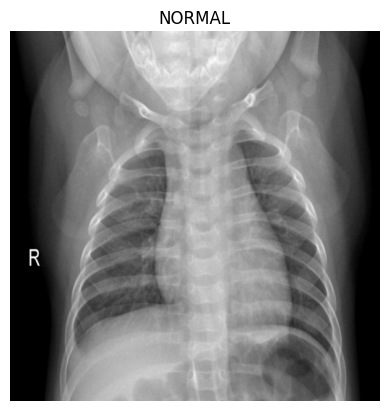

In [6]:
# Plot one example
# get next image
images, labels = next(iter(train))

# to numpy
image = images[0].numpy()
label = labels[0].item()

# convert tensor shape (channels, height, width) to (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# def classes
classes = ['NORMAL', 'PNEUMONIA']

# plot
plt.imshow(image)
plt.title(classes[label])
plt.axis('off')
plt.show()

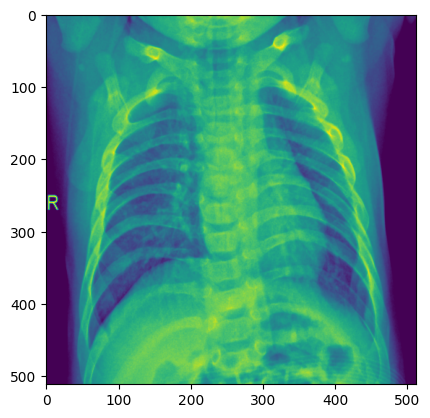

In [ ]:
#images, labels = next(iter(train))
plt.imshow(images[5,0,:,:])

In [ ]:
images[:,0,:,:].size()

torch.Size([32, 512, 512])

In [ ]:
labels.size()

torch.Size([32])

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.densenet121(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(ftrs, 1) #final linear output layer

    def forward(self, x):
        x = self.model(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 131MB/s]


In [8]:
# set
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [8]:
# train one epoche
def train_epoch(model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    acc_train = torchmetrics.Accuracy('binary').to(device)

    for images, labels in train:

        images, labels = images.to(device), labels.to(device).to(torch.float32)

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        acc_train(outputs, labels.int())

    return model, running_loss/len(train), acc_train.compute().item()

In [9]:
# evaluate in validatio set
def evaluate(model, criterion):
  model.eval()
  with torch.no_grad():
    val_loss = 0
    acc_valid = torchmetrics.Accuracy('binary').to(device)

    for images, labels in val:

      images, labels = images.to(device), labels.to(device).to(torch.float32)

      outputs = model(images).squeeze()
      loss = criterion(outputs, labels)

      val_loss += loss.item()
      acc_valid(outputs, labels.int())

  return val_loss/len(val), acc_valid.compute()

In [10]:
# evaluate on test set
def evaluate_test(model, criterion):
  model.eval()
  with torch.no_grad():
    test_loss = 0
    acc_valid = torchmetrics.Accuracy('binary').to(device)

    for images, labels in test:

      images, labels = images.to(device), labels.to(device).to(torch.float32)

      outputs = model(images).squeeze()
      loss = criterion(outputs, labels)

      test_loss += loss.item()
      acc_valid(outputs, labels.int())

  return test_loss/len(test), acc_valid.compute()

In [ ]:
# train
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  print(f"Epoch: {epoch+1}/{num_epochs}")

  model, loss_train, acc_train = train_epoch(model, criterion, optimizer)
  loss_valid, acc_valid = evaluate(model, criterion)

  acc_valid = acc_valid.cpu().numpy()
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f"Train: Loss {loss_train:.2}, Accuracy {acc_train:.2}; Validation: Loss {loss_valid:.2}, Accuracy {acc_valid:.2}")

Epoch: 1/10
Train: Loss 0.37, Accuracy 0.83; Validation: Loss 0.57, Accuracy 0.62
Epoch: 2/10
Train: Loss 0.22, Accuracy 0.92; Validation: Loss 0.64, Accuracy 0.56
Epoch: 3/10
Train: Loss 0.19, Accuracy 0.93; Validation: Loss 0.58, Accuracy 0.62
Epoch: 4/10


In [ ]:
print("loss_train_hist:", loss_train_hist)
print("loss_valid_hist:", loss_valid_hist)
print("acc_train_hist:", acc_train_hist)
print("acc_valid_hist:", acc_valid_hist)

In [ ]:
print(evaluate_test(model, criterion))

In [ ]:
torch.save(model.state_dict(), 'trained_model_240416_512pix_10epochs.pth')
#model_save_name = 'resnet50_model_trained.pt'
#path = F"/content/gdrive/'My Drive'/{model_save_name}"
#torch.save(model.state_dict(), path)

In [9]:
# load new saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
state_dict = torch.load('/content/drive/MyDrive/ETH/MSc/ML 4 Healthcare/Project_01/trained_model_240416_200pix_10epochs.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)

CNN(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

In [ ]:
epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_train_hist, 'b', label='Training')
plt.plot(epochs, loss_valid_hist, 'r', label='Validation')
plt.title('Training and Validation - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc_train_hist, 'b', label='Training')
plt.plot(epochs, acc_valid_hist, 'r', label='Validation')
plt.title('Training and Validation - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
targets = []
predictions = []

with torch.no_grad():
    model.eval()
    for images, labels in test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        targets.extend(labels.cpu().numpy())
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        predictions.extend(preds)

print(classification_report(targets, predictions))

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(targets, predictions, pos_label=1)
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='AUC = {:.4f})'.format(auc), color='black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - Test')
plt.legend(loc='best')
plt.show()

In [ ]:
model(images.to(device))

Integrated Gradients

In [10]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00


In [19]:
from captum.attr import IntegratedGradients

def attribute_image_features(algorithm, input, target_index, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=target_index, **kwargs)
    return tensor_attributions

target_class_index = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate batches
for batch_idx, (images, labels) in enumerate(test):
    images.to(device)
    labels.to(device)

    # Attribute image features for each image in the batch
    for img_idx, img_tensor in enumerate(images):
        input = img_tensor.unsqueeze(0).to(device)
        input.requires_grad = True

        # Integrated Gradients
        ig = IntegratedGradients(model)

        # Attribute image features
        attr_ig, delta = attribute_image_features(ig, input, target_class_index, baselines=input * 0, return_convergence_delta=True)
        attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
        print(f'Approximation delta for Batch {batch_idx}, Image {img_idx}: ', abs(delta))

OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 29.06 MiB is free. Process 2881 has 14.72 GiB memory in use. Of the allocated memory 14.58 GiB is allocated by PyTorch, and 9.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
attr_ig[0]

NameError: name 'attr_ig' is not defined

In [ ]:
## project on image
import matplotlib.pyplot as plt

# Assuming `image` is your original image and `attr_ig` is the attributions obtained from Integrated Gradients
# Both should be numpy arrays of the same shape

# Normalize attributions to [0, 1]
attr_ig_scaled = (attr_ig - attr_ig.min()) / (attr_ig.max() - attr_ig.min())

# Apply the attributions to the original image
ind = 0
print(labels[ind])
image = images[ind,0,:,:]
projected_image =  image * attr_ig_scaled[:,:,0]

# Plot the original image and the projected image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(projected_image)
plt.title('Projected Image')

plt.show()

In [ ]:
## project on image
import matplotlib.pyplot as plt

# Plot one example
# get next image
images, labels = next(iter(test))

# to numpy
image = images[0].numpy()
label = labels[0].item()

# convert tensor shape (channels, height, width) to (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# def classes
classes = ['NORMAL', 'PNEUMONIA']

# normalize attributions to [0, 1]
attr_ig_scaled = (attr_ig - attr_ig.min()) / (attr_ig.max() - attr_ig.min())

#project
projected_image =  image * attr_ig_scaled

# Plot the original image and the projected image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image - {}'.format(classes[label]))

plt.subplot(1, 2, 2)
plt.imshow(projected_image)
plt.title('Projected Image')

plt.show()

In [ ]:
target_classes = []
for _, labels in test:
    target_classes.extend(labels.tolist())

print(target_classes)

Grad-CAM

https://github.com/jacobgil/pytorch-grad-cam

In [21]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38071 sha256=4bf18c68b6c6a32a29a6a2b7e7a8cbc47464e46f0117e10b6aa733a1b3d06cdf
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


In [22]:
print(model.model.features)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

In [23]:
# Initialize GradCAM
#target_layer = model.model.classifier
#target_layer = model.model.features[-1]
#target_layer = model.model.features.denseblock4
target_layer = model.model.features[-1]
gradcam = GradCAM(model=model, target_layers=target_layer)

# Get a batch of images and labels from the test set
images, labels = next(iter(test))
images = images.to(device)

# Forward pass
output = model(images)
probs = torch.sigmoid(output)

# Generate Grad-CAM for the positive class (you can adjust the target category)
cam = gradcam(input_tensor=images, target_category=0)

# Convert tensors to numpy arrays
input_images_np = images.cpu().numpy()
cam_np = cam.cpu().numpy()

# Normalize Grad-CAM values to [0, 1]
cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())

# Upsample Grad-CAM to input image size
cam_upsampled = [cv2.resize(cam_map, (input_img.shape[2], input_img.shape[1])) for cam_map, input_img in zip(cam_np, input_images_np)]

# Convert input images to uint8 format for visualization
input_images_uint8 = (input_images_np * 255).astype(np.uint8)

# Visualize Grad-CAM on input images
visualizations = [show_cam_on_image(input_img.transpose(1, 2, 0), cam_map) for input_img, cam_map in zip(input_images_uint8, cam_upsampled)]

# Display the visualizations
for i, visualization in enumerate(visualizations):
    cv2.imshow(f'Grad-CAM Image {i}', visualization)

cv2.waitKey(0)
cv2.destroyAllWindows()

TypeError: 'BatchNorm2d' object is not iterable

In [24]:
pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 877.7 kB/s eta 0:00:00


In [26]:
from torchcam.methods import GradCAM
model.eval()
target_layer = model.model.classifier
cam = GradCAM(model, target_layer)

images, labels = next(iter(test))
images = images.to(device)

scores = model(images)
cam(class_idx=0, scores=scores)

Exception ignored in: <function BaseCAM.__del__ at 0x7cc1b05679a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [27]:
target_layer = model.model.classifier
#target_layer = model.model.features[-1]
#target_layer = model.model.features.denseblock4
cam = GradCAM(model=model, target_layer=target_layer) #, input_shape=[32, 3, 200, 200]

# Get a batch of images and labels from the test set
images, labels = next(iter(test))  # Assuming 'test' is your DataLoader

# Move images to the same device as the model
images = images.to(device)

# Forward pass
output = model(images)
#print(output)
probs = torch.sigmoid(output)
#print(probs)

# Generate Grad-CAM for class index 0 (you can adjust the class index as needed)
cam(class_idx=0, scores=output)

# Now, you can access the generated CAM heatmap using cam.image[0]
# For example, you can visualize it with matplotlib
import matplotlib.pyplot as plt
plt.imshow(cam.images[0], cmap='jet')
plt.axis('off')
plt.show()

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
images.size()

torch.Size([32, 3, 200, 200])

In [28]:
import sys
sys.path.append('/kaggle/input/gradcam')

In [35]:
#from gradcam import GradCAM
heatmaps = []
model.eval()

images, labels = next(iter(test))  # Assuming 'test' is your DataLoader
images = images.to(device)

preds = model(images)
i = np.argmax(preds.cpu().detach())

#target_layer = model.model.features.denseblock4
target_layer = model.model.classifier
#target_layer = model.model.features[-1]
#target_layer = model.model.features.denseblock4

cam = GradCAM(target_layer, i)
heatmap = cam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (IMG_DIM, IMG_DIM))
heatmaps.append(heatmap)

heatmaps = np.array(heatmaps,dtype='float32')

TypeError: invalid argument type for `target_layer`

Data Randomization Test

In [ ]:
# Shuffle the labels
labels = torch.tensor(dataset.targets)
shuffled_labels = labels[torch.randperm(len(labels))]

# Replace the labels in the dataset with the shuffled labels
dataset.targets = shuffled_labels.tolist()

# Create a DataLoader with the modified dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Iterate over the dataloader to access batches with shuffled labels
for images, labels in dataloader:
    # Perform your training/validation/testing operations here
    pass